In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

import tensorflow
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.utils import shuffle 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path_benih = '/content/drive/My Drive/Penelitian/Dataset/'

In [ ]:
kelas = ['haploid', 'diploid']
kelas

['haploid', 'diploid']

In [ ]:
def get_data(data_dir):
    size = (224,224)
    label = 0
    x = []
    y = []
    for folder in kelas:
        print("Loading {}".format(data_dir+folder))
        for pic in tqdm(glob.glob(data_dir + folder + '/*')):
            im = cv2.imread(pic)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, (size))
            im = np.array(im)
            x.append(im)
            y.append(label)
        label+=1
    x = np.array(x, dtype = 'float32')
    y = np.array(y, dtype = 'int32')
    return x,y

In [ ]:
x_train, y_train = get_data(path_benih + 'train/')
x_test, y_test = get_data(path_benih + 'test/')

Loading /content/drive/My Drive/Penelitian/Dataset/train/haploid


100%|██████████| 984/984 [00:21<00:00, 45.69it/s] 


Loading /content/drive/My Drive/Penelitian/Dataset/train/diploid


100%|██████████| 1416/1416 [00:34<00:00, 41.06it/s] 


Loading /content/drive/My Drive/Penelitian/Dataset/test/haploid


100%|██████████| 246/246 [00:05<00:00, 42.82it/s] 


Loading /content/drive/My Drive/Penelitian/Dataset/test/diploid


100%|██████████| 354/354 [00:07<00:00, 48.25it/s] 


In [ ]:
x_train/=255.
x_test/=255.

In [ ]:
len(x_train)+len(x_test)

3000

In [ ]:
def balanced(y_train):
  labels_count = np.unique(y_train, return_counts=True)
  plt.figure(figsize=(8,12))
  plt.rcParams['font.size'] = 18
  plt.pie(labels_count[1],
          labels=kelas,
          autopct='%1.1f%%')
  plt.title('Perbandingan Haploid dan Diploid', size=23)
  plt.show()

#### Training Data

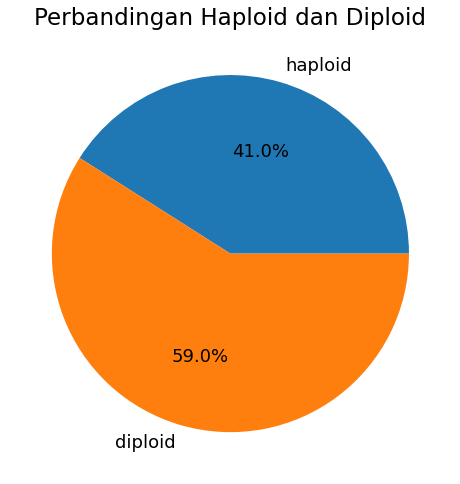

In [ ]:
balanced(y_train)

In [ ]:
rus = RandomUnderSampler(random_state=42)
n_sample, height, width, channel = x_train.shape

x_train, y_train = rus.fit_resample(
    x_train.reshape((n_sample, height*width*channel)), y_train)

In [ ]:
x_train = x_train.reshape((x_train.shape[0], 224, 224, 3))

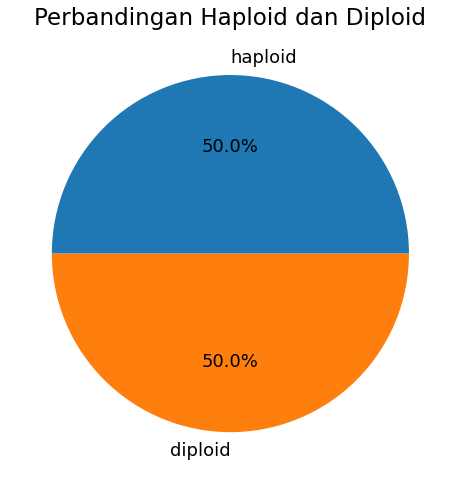

In [ ]:
balanced(y_train)

#### Testing Data

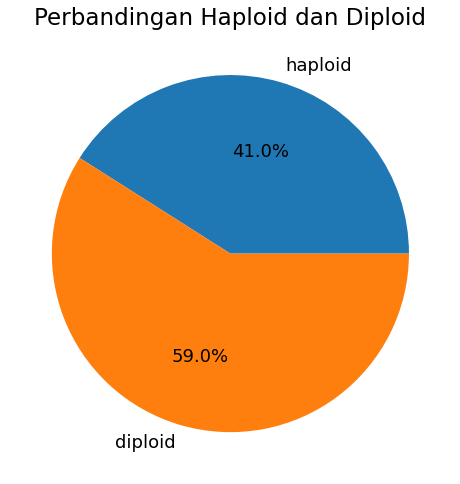

In [ ]:
balanced(y_test)

In [ ]:
rus = RandomUnderSampler(random_state=42)
n_sample, height, width, channel = x_test.shape

x_test, y_test = rus.fit_resample(
    x_test.reshape((n_sample, height*width*channel)), y_test)

In [ ]:
x_test = x_test.reshape((x_test.shape[0], 224, 224, 3))

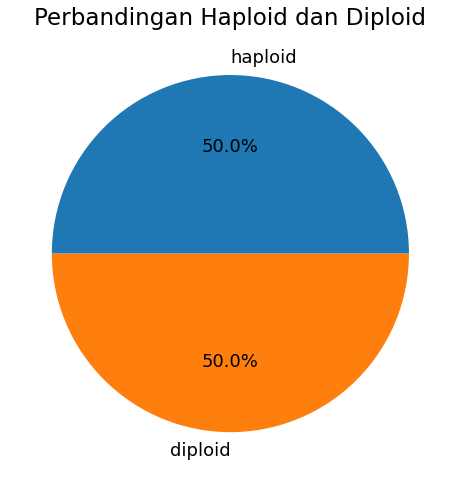

In [ ]:
balanced(y_test)

In [ ]:
len(x_train)+len(x_test)

2460

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [ ]:
# Import Best Model dari Ujicoba_1
best_dir = '/content/drive/My Drive/Penelitian/save_models/percobaan_3/'
model = load_model(best_dir+"model_2")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def print_layer_trainable(models):
  for layer in models.layers:
    print('{}:\t{}'.format(layer.trainable, layer.name))

In [ ]:
print_layer_trainable(model)

True:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_conv4
False:	block5_pool
True:	flatten
True:	dense
True:	dropout
True:	dense_1
True:	dropout_1
True:	dense_2


In [ ]:
model.trainable = True
print("Layer pada model: {}".format(len(model.layers)))

Layer pada model: 28


In [ ]:
fine_tune_at = 14
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
print_layer_trainable(model)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
True:	block4_conv3
True:	block4_conv4
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_conv4
True:	block5_pool
True:	flatten
True:	dense
True:	dropout
True:	dense_1
True:	dropout_1
True:	dense_2


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def get_model_name(k):
  return 'model_'+str(k)

In [ ]:
akurasi_val_data=[]
AUC=[]
CV=[]
waktu=[]

LOSS=[]
VAL_LOSS=[]
ACCURACY=[]
VAL_ACCURACY=[]

fold_var = 1
max_epoch = 64
batch_size = 32
lr = 0.0001

save_dir = '/content/drive/My Drive/Penelitian/save_models/percobaan_4/'

In [ ]:
kf = StratifiedKFold(n_splits=5)
for train_index, val_index in kf.split(x_train, y_train):
  print("---------- FOLD KE- {} ----------".format(fold_var))
  x_training, y_training = x_train[train_index], y_train[train_index]
  x_validasi, y_validasi = x_train[val_index], y_train[val_index]

  y_training = to_categorical(y_training)   
  y_validasi = to_categorical(y_validasi)

  model.compile(optimizer=Adam(learning_rate=lr), 
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # min_delta (perubahan minimal), patience (jumlah epoch tanpa perbaikan)
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, verbose=1, mode='auto')
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var),
                               monitor='val_accuracy', verbose=1,
                               save_best_only=True, mode='max')
  callback_list = [early_stop, checkpoint]

  start = datetime.datetime.now()
  hist = model.fit(x_training, y_training, 
                   epochs=max_epoch,
                   batch_size=batch_size,
                   callbacks=callback_list,
                   validation_data = (x_validasi, y_validasi))
  end = datetime.datetime.now()
  jam = end - start

  model = load_model(save_dir+"model_"+str(fold_var))

  predict = model.predict(x_validasi)
  predict = np.argmax(predict, axis=1)
  labels = np.argmax(y_validasi, axis=1)
  print(classification_report(labels, predict, target_names = ['Haploid (Class 0)','Diploid (Class 1)']))
  print('Waktu Pelatihan Data : ', jam, '\n\n')
  acc = accuracy_score(labels, predict)
  auc = roc_auc_score(labels, predict)

  waktu.append(jam)
  akurasi_val_data.append(acc)
  AUC.append(auc)
  LOSS.append(hist.history['loss'])
  ACCURACY.append(hist.history['accuracy'])
  VAL_LOSS.append(hist.history['val_loss'])
  VAL_ACCURACY.append(hist.history['val_accuracy'])
  CV.append('CV-'+str(fold_var))

  clear_session()
  fold_var+=1

---------- FOLD KE- 1 ----------
Epoch 1/64
50/50 [==============================] - ETA: 0s - loss: 0.8586 - accuracy: 0.5305
Epoch 1: val_accuracy improved from -inf to 0.53299, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_4/model_1


50/50 [==============================] - 35s 453ms/step - loss: 0.8586 - accuracy: 0.5305 - val_loss: 0.6634 - val_accuracy: 0.5330
Epoch 2/64
50/50 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.6970
Epoch 2: val_accuracy improved from 0.53299 to 0.57614, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_4/model_1


50/50 [==============================] - 20s 409ms/step - loss: 0.5762 - accuracy: 0.6970 - val_loss: 0.8525 - val_accuracy: 0.5761
Epoch 3/64
50/50 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.7421
Epoch 3: val_accuracy improved from 0.57614 to 0.86548, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_4/model_1


50/50 [==============================] - 21s 422ms/step - loss: 0.5024 - accuracy: 0.7421 - val_loss: 0.3346 - val_accuracy: 0.8655
Epoch 4/64
50/50 [==============================] - ETA: 0s - loss: 0.3301 - accuracy: 0.8628
Epoch 4: val_accuracy improved from 0.86548 to 0.90102, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_4/model_1


50/50 [==============================] - 21s 419ms/step - loss: 0.3301 - accuracy: 0.8628 - val_loss: 0.2856 - val_accuracy: 0.9010
Epoch 5/64
50/50 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.8799
Epoch 5: val_accuracy improved from 0.90102 to 0.90355, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_4/model_1


50/50 [==============================] - 21s 421ms/step - loss: 0.2968 - accuracy: 0.8799 - val_loss: 0.2774 - val_accuracy: 0.9036
Epoch 6/64
50/50 [==============================] - ETA: 0s - loss: 0.2548 - accuracy: 0.9041
Epoch 6: val_accuracy improved from 0.90355 to 0.92132, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_4/model_1


50/50 [==============================] - 21s 419ms/step - loss: 0.2548 - accuracy: 0.9041 - val_loss: 0.2643 - val_accuracy: 0.9213
Epoch 7/64
50/50 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9117
Epoch 7: val_accuracy did not improve from 0.92132
50/50 [==============================] - 16s 311ms/step - loss: 0.2256 - accuracy: 0.9117 - val_loss: 0.2544 - val_accuracy: 0.9061
Epoch 8/64
50/50 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9104
Epoch 8: val_accuracy did not improve from 0.92132
50/50 [==============================] - 16s 317ms/step - loss: 0.2330 - accuracy: 0.9104 - val_loss: 0.2413 - val_accuracy: 0.9188
Epoch 9/64
50/50 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9365
Epoch 9: val_accuracy did not improve from 0.92132
50/50 [==============================] - 15s 310ms/step - loss: 0.1740 - accuracy: 0.9365 - val_loss: 0.2828 - val_accuracy: 0.9061
Epoch 10/64
50/50 [==================

50/50 [==============================] - 20s 408ms/step - loss: 0.1647 - accuracy: 0.9384 - val_loss: 0.2236 - val_accuracy: 0.9289
Epoch 11/64
50/50 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9422
Epoch 11: val_accuracy did not improve from 0.92893
50/50 [==============================] - 15s 306ms/step - loss: 0.1457 - accuracy: 0.9422 - val_loss: 0.2383 - val_accuracy: 0.9213
Epoch 12/64
50/50 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9282
Epoch 12: val_accuracy improved from 0.92893 to 0.93401, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_4/model_1


50/50 [==============================] - 20s 405ms/step - loss: 0.1687 - accuracy: 0.9282 - val_loss: 0.2291 - val_accuracy: 0.9340
Epoch 13/64
50/50 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9581
Epoch 13: val_accuracy did not improve from 0.93401
50/50 [==============================] - 15s 310ms/step - loss: 0.1180 - accuracy: 0.9581 - val_loss: 0.2953 - val_accuracy: 0.9289
Epoch 14/64
50/50 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9524
Epoch 14: val_accuracy did not improve from 0.93401
50/50 [==============================] - 16s 311ms/step - loss: 0.1350 - accuracy: 0.9524 - val_loss: 0.3145 - val_accuracy: 0.9162
Epoch 15/64
50/50 [==============================] - ETA: 0s - loss: 0.1321 - accuracy: 0.9460
Epoch 15: val_accuracy did not improve from 0.93401
50/50 [==============================] - 15s 309ms/step - loss: 0.1321 - accuracy: 0.9460 - val_loss: 0.2868 - val_accuracy: 0.9162
Epoch 16/64
50/50 [============

50/50 [==============================] - 22s 416ms/step - loss: 0.2154 - accuracy: 0.9238 - val_loss: 0.1229 - val_accuracy: 0.9619
Epoch 2/64
50/50 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9454
Epoch 2: val_accuracy did not improve from 0.96193
50/50 [==============================] - 16s 310ms/step - loss: 0.1505 - accuracy: 0.9454 - val_loss: 0.1493 - val_accuracy: 0.9315
Epoch 3/64
50/50 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9549
Epoch 3: val_accuracy did not improve from 0.96193
50/50 [==============================] - 16s 314ms/step - loss: 0.1190 - accuracy: 0.9549 - val_loss: 0.1477 - val_accuracy: 0.9416
Epoch 4/64
50/50 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9587
Epoch 4: val_accuracy did not improve from 0.96193
50/50 [==============================] - 15s 309ms/step - loss: 0.1082 - accuracy: 0.9587 - val_loss: 0.1661 - val_accuracy: 0.9289
Epoch 5/64
50/50 [===================

50/50 [==============================] - 21s 409ms/step - loss: 0.2278 - accuracy: 0.9263 - val_loss: 0.1773 - val_accuracy: 0.9315
Epoch 2/64
50/50 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9555
Epoch 2: val_accuracy improved from 0.93147 to 0.95178, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_4/model_3


50/50 [==============================] - 21s 420ms/step - loss: 0.1232 - accuracy: 0.9555 - val_loss: 0.1375 - val_accuracy: 0.9518
Epoch 3/64
50/50 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9644
Epoch 3: val_accuracy did not improve from 0.95178
50/50 [==============================] - 16s 311ms/step - loss: 0.0942 - accuracy: 0.9644 - val_loss: 0.1839 - val_accuracy: 0.9365
Epoch 4/64
50/50 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.9606
Epoch 4: val_accuracy did not improve from 0.95178
50/50 [==============================] - 15s 311ms/step - loss: 0.1071 - accuracy: 0.9606 - val_loss: 0.1402 - val_accuracy: 0.9518
Epoch 5/64
50/50 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.9524
Epoch 5: val_accuracy did not improve from 0.95178
50/50 [==============================] - 15s 309ms/step - loss: 0.1402 - accuracy: 0.9524 - val_loss: 0.1758 - val_accuracy: 0.9289
Epoch 6/64
50/50 [===================

50/50 [==============================] - 24s 474ms/step - loss: 0.1450 - accuracy: 0.9429 - val_loss: 0.1166 - val_accuracy: 0.9542
Epoch 2/64
50/50 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9505
Epoch 2: val_accuracy improved from 0.95420 to 0.96692, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_4/model_4


50/50 [==============================] - 20s 410ms/step - loss: 0.1368 - accuracy: 0.9505 - val_loss: 0.0950 - val_accuracy: 0.9669
Epoch 3/64
50/50 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9676
Epoch 3: val_accuracy did not improve from 0.96692
50/50 [==============================] - 16s 311ms/step - loss: 0.0976 - accuracy: 0.9676 - val_loss: 0.0997 - val_accuracy: 0.9517
Epoch 4/64
50/50 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9663
Epoch 4: val_accuracy did not improve from 0.96692
50/50 [==============================] - 16s 312ms/step - loss: 0.0859 - accuracy: 0.9663 - val_loss: 0.1277 - val_accuracy: 0.9567
Epoch 5/64
50/50 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9752
Epoch 5: val_accuracy did not improve from 0.96692
50/50 [==============================] - 16s 313ms/step - loss: 0.0656 - accuracy: 0.9752 - val_loss: 0.1800 - val_accuracy: 0.9313
Epoch 6/64
50/50 [===================

50/50 [==============================] - 22s 416ms/step - loss: 0.1307 - accuracy: 0.9581 - val_loss: 0.1372 - val_accuracy: 0.9466
Epoch 2/64
50/50 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9695
Epoch 2: val_accuracy improved from 0.94656 to 0.95420, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_4/model_5


50/50 [==============================] - 20s 408ms/step - loss: 0.0878 - accuracy: 0.9695 - val_loss: 0.1141 - val_accuracy: 0.9542
Epoch 3/64
50/50 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.9689
Epoch 3: val_accuracy did not improve from 0.95420
50/50 [==============================] - 16s 311ms/step - loss: 0.1020 - accuracy: 0.9689 - val_loss: 0.1336 - val_accuracy: 0.9542
Epoch 4/64
50/50 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9816
Epoch 4: val_accuracy improved from 0.95420 to 0.98728, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_4/model_5


50/50 [==============================] - 20s 410ms/step - loss: 0.0624 - accuracy: 0.9816 - val_loss: 0.0779 - val_accuracy: 0.9873
Epoch 5/64
50/50 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9752
Epoch 5: val_accuracy did not improve from 0.98728
50/50 [==============================] - 15s 305ms/step - loss: 0.0691 - accuracy: 0.9752 - val_loss: 0.5824 - val_accuracy: 0.8193
Epoch 6/64
50/50 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9543
Epoch 6: val_accuracy did not improve from 0.98728
50/50 [==============================] - 15s 309ms/step - loss: 0.1133 - accuracy: 0.9543 - val_loss: 0.0836 - val_accuracy: 0.9695
Epoch 7/64
50/50 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9898
Epoch 7: val_accuracy did not improve from 0.98728
50/50 [==============================] - 15s 310ms/step - loss: 0.0362 - accuracy: 0.9898 - val_loss: 0.0714 - val_accuracy: 0.9796
Epoch 8/64
50/50 [===================

In [ ]:
print(akurasi_val_data)
print(AUC)
print(CV)
print(waktu)

print(LOSS)
print(VAL_LOSS)
print(ACCURACY)
print(VAL_ACCURACY)

[0.934010152284264, 0.9619289340101523, 0.9517766497461929, 0.9669211195928753, 0.9872773536895675]
[0.9340101522842641, 0.9619289340101523, 0.9517766497461929, 0.9668885320625713, 0.9872707966435306]
['CV-1', 'CV-2', 'CV-3', 'CV-4', 'CV-5']
[datetime.timedelta(seconds=319, microseconds=502635), datetime.timedelta(seconds=192, microseconds=199040), datetime.timedelta(seconds=150, microseconds=493989), datetime.timedelta(seconds=153, microseconds=973007), datetime.timedelta(seconds=231, microseconds=886887)]
[[0.8585941791534424, 0.57618248462677, 0.5023874640464783, 0.33014702796936035, 0.29678845405578613, 0.25483301281929016, 0.22561344504356384, 0.2329811304807663, 0.1740172952413559, 0.16473987698554993, 0.1457466334104538, 0.16866055130958557, 0.11802184581756592, 0.13495351374149323, 0.13212719559669495, 0.08686883747577667, 0.07070755213499069], [0.21541166305541992, 0.1504923403263092, 0.11897943168878555, 0.10816037654876709, 0.10269422084093094, 0.06866268068552017, 0.0629975

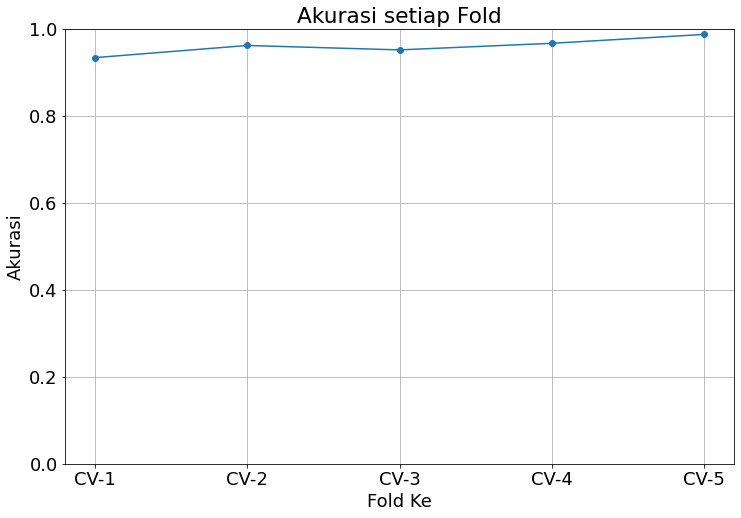

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(CV, akurasi_val_data, marker='o')
plt.title('Akurasi setiap Fold')
plt.xlabel('Fold Ke')
plt.ylabel('Akurasi')
plt.ylim((0., 1))
plt.grid()
plt.show()

In [ ]:
def visualisasi_fit(judul, n_train, n_val):
  fig, ax = plt.subplots(3,2,constrained_layout=True, figsize=(15,10))
  index=0
  for i in range(3):
    for j in range(2):
      if j==0:
        ax[i,j].set_title('CV' + str(index+1) + judul)
        ax[i,j].plot(n_train[index], '--', label=judul)
        ax[i,j].plot(n_val[index], label='Val_'+judul)
        ax[i,j].set_xlabel('x-axis')
        ax[i,j].set_ylabel('y-axis')
      else:
        if index==5:
          break
        ax[i,j].set_title('CV' + str(index+1) + judul)
        ax[i,j].set_xlabel('x-axis')
        ax[i,j].set_ylabel('y-axis')
        ax[i,j].plot(n_train[index], '--', label=judul)
        ax[i,j].plot(n_val[index], label='Val_'+judul)
      ax[i,j].grid()
      ax[i,j].set_ylim((0., 1))
      ax[i,j].legend()
      index+=1

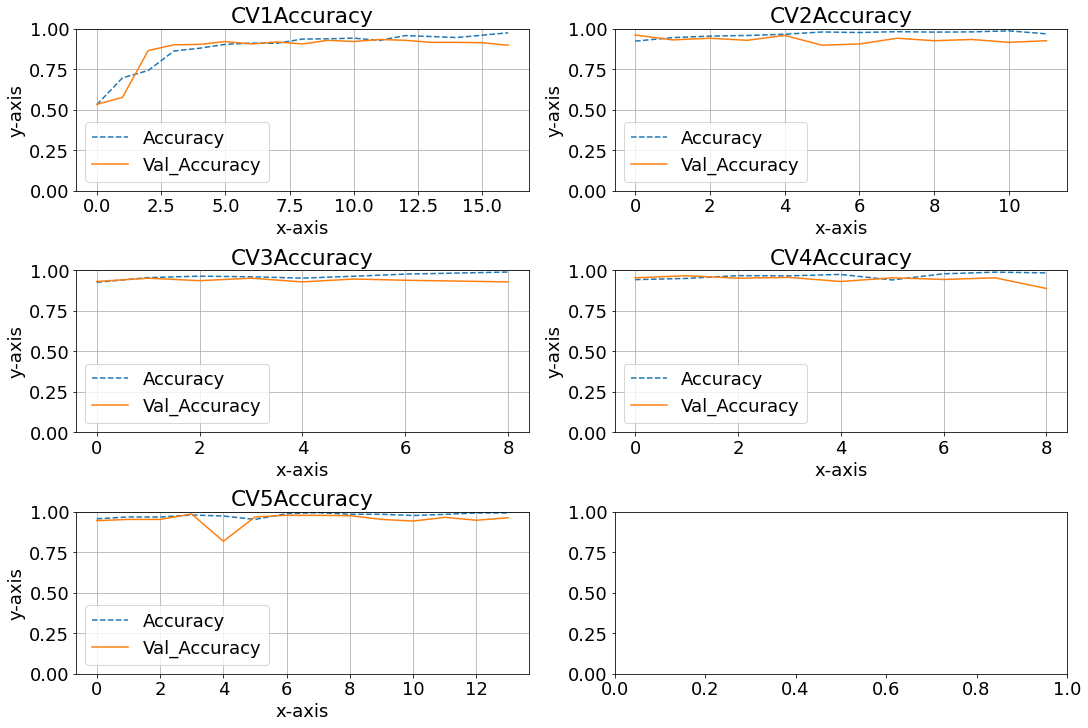

In [ ]:
vis_akurasi = visualisasi_fit('Accuracy', ACCURACY, VAL_ACCURACY)
vis_akurasi

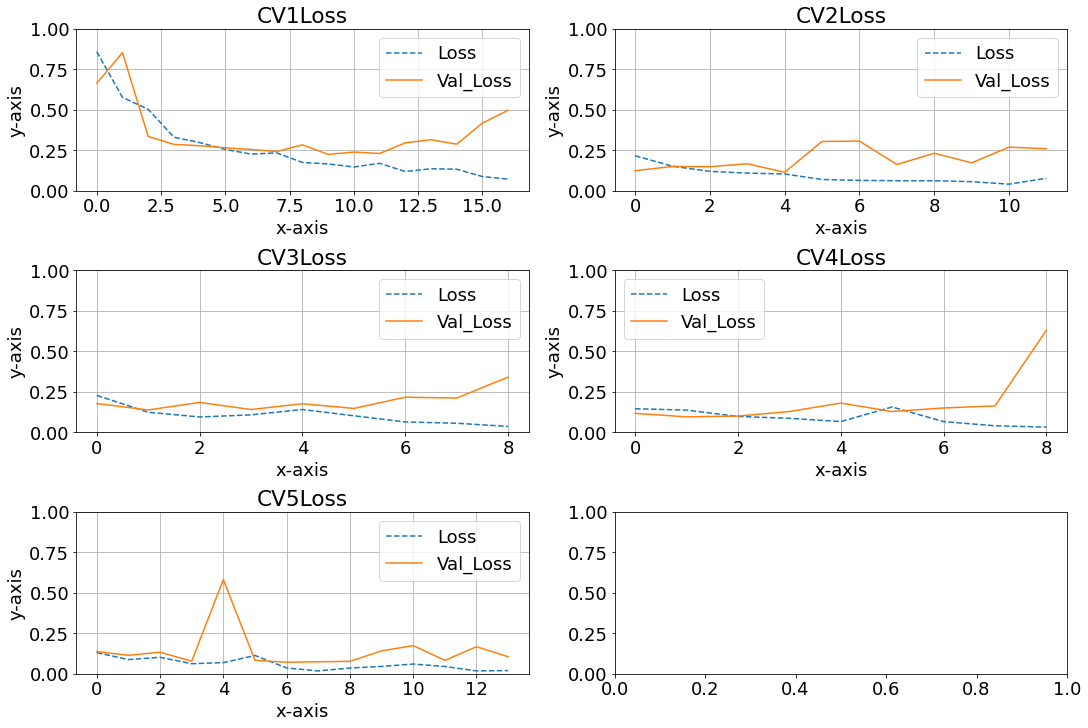

In [ ]:
vis_loss = visualisasi_fit('Loss', LOSS, VAL_LOSS)
vis_loss

In [ ]:
terbaik=[]
for i in range(5):
  nilai = (akurasi_val_data[i]+AUC[i])/2
  terbaik.append(nilai)

In [ ]:
terbaik

[0.9340101522842641,
 0.9619289340101523,
 0.9517766497461929,
 0.9669048258277233,
 0.987274075166549]

In [ ]:
s=0
baik=1
for i, v in enumerate(terbaik):
  if v>s:
    s=v
    baik=i+1
  else:
    continue
print(baik, s)

5 0.987274075166549


In [ ]:
model = load_model(save_dir+"model_"+str(baik))
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

16/16 [==============================] - 5s 297ms/step


In [ ]:
acc_test = accuracy_score(y_test, y_pred)
prec_test = precision_score(y_test, y_pred)
rec_test = recall_score(y_test, y_pred)
f1score_test = f1_score(y_test, y_pred)

In [ ]:
print('Acc Test : ', acc_test)
print('Prec Test : ', prec_test)
print('Rec Test : ', rec_test)
print('F1-Score Test : ', f1score_test)

Acc Test :  0.9654471544715447
Prec Test :  0.9420849420849421
Rec Test :  0.991869918699187
F1-Score Test :  0.9663366336633663


In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Haploid (Class 0)','Diploid (Class 1)']))

                   precision    recall  f1-score   support

Haploid (Class 0)       0.99      0.94      0.96       246
Diploid (Class 1)       0.94      0.99      0.97       246

         accuracy                           0.97       492
        macro avg       0.97      0.97      0.97       492
     weighted avg       0.97      0.97      0.97       492



In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[231,  15],
       [  2, 244]])

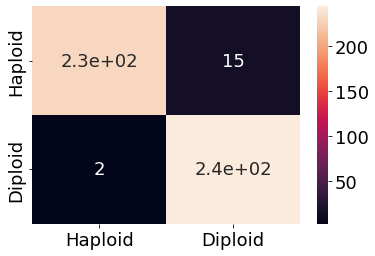

In [ ]:
sns.heatmap(cm, annot=True, xticklabels=['Haploid', 'Diploid'], yticklabels=['Haploid', 'Diploid'])

In [ ]:
def plot_roc_curve(true_y, y_prob): 
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Model AUC score : 0.9654471544715446


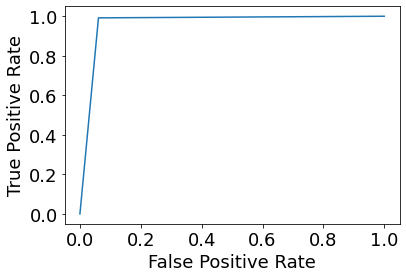

In [ ]:
plot_roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print('Model AUC score : {}'.format(auc))

In [ ]:
x_test, y_test = get_data(path_benih + 'test/')

Loading /content/drive/My Drive/Penelitian/Dataset/test/haploid


100%|██████████| 246/246 [00:01<00:00, 165.28it/s]


Loading /content/drive/My Drive/Penelitian/Dataset/test/diploid


100%|██████████| 354/354 [00:02<00:00, 149.04it/s]


In [ ]:
x_test/=255.

In [ ]:
model = load_model(save_dir+"model_"+str(baik))
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

19/19 [==============================] - 6s 329ms/step


In [ ]:
acc_test = accuracy_score(y_test, y_pred)
prec_test = precision_score(y_test, y_pred)
rec_test = recall_score(y_test, y_pred)
f1score_test = f1_score(y_test, y_pred)

In [ ]:
print('Acc Test : ', acc_test)
print('Prec Test : ', prec_test)
print('Rec Test : ', rec_test)
print('F1-Score Test : ', f1score_test)

Acc Test :  0.9683333333333334
Prec Test :  0.958904109589041
Rec Test :  0.9887005649717514
F1-Score Test :  0.9735744089012517


In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Haploid (Class 0)','Diploid (Class 1)']))

                   precision    recall  f1-score   support

Haploid (Class 0)       0.98      0.94      0.96       246
Diploid (Class 1)       0.96      0.99      0.97       354

         accuracy                           0.97       600
        macro avg       0.97      0.96      0.97       600
     weighted avg       0.97      0.97      0.97       600



In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[231,  15],
       [  4, 350]])

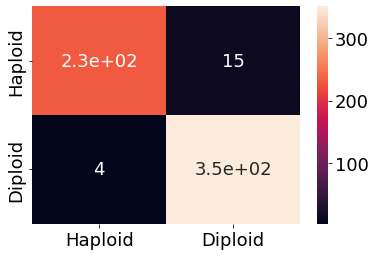

In [ ]:
sns.heatmap(cm, annot=True, xticklabels=['Haploid', 'Diploid'], yticklabels=['Haploid', 'Diploid'])

In [ ]:
def plot_roc_curve(true_y, y_prob): 
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Model AUC score : 0.9638624776078268


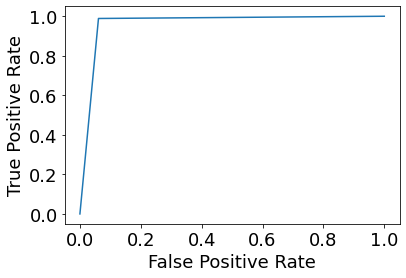

In [ ]:
plot_roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print('Model AUC score : {}'.format(auc))